File used for testing the functions in the repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd

In [2]:
# import predict_polynomial_signal from Predicted_signal.py
from source.Losses import MSE, compute_parameter_loss
from source.Predicted_signal import predict_polynomial
from data.Polynomial_test import generate_polynomial_data
from data.Polynomial_test import load_polynomial_data

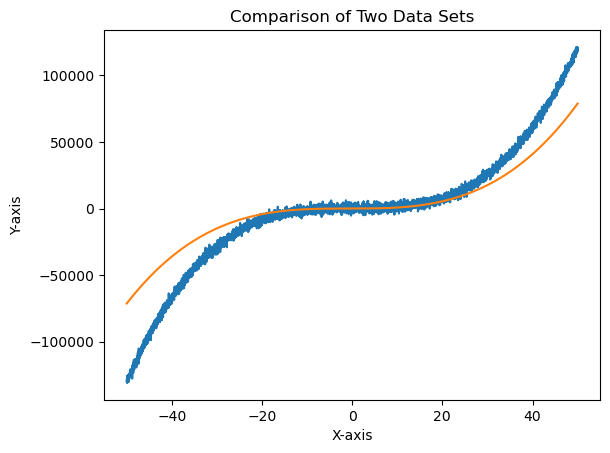

MSE: 376669053.2978912


In [3]:
# Coefficients for the polynomial (a0, a1, a2, a3, a4)
true_coefficients = [250, 2.5, -2, 1]
list = np.linspace(-50, 50, 5000)
estimated_coefficients = [0, 1.2, 1.5, 0.6]

result = generate_polynomial_data(true_coefficients, list, noise_level=2000)
prediction = predict_polynomial(estimated_coefficients, list)

plt.plot(list, result)
plt.plot(list, prediction)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of Two Data Sets')

plt.show()

print("MSE:", MSE(result, prediction))

In [4]:
# Get two tensors

a = np.array([1, 2, 3, 4, -7])
b = np.array([1, 2, 3, 4, 5])

inputs_tensor = torch.tensor(a, dtype=torch.float32)
true_params_tensor = torch.tensor(b, dtype=torch.float32)


print("Parameter Loss:", compute_parameter_loss(inputs_tensor, true_params_tensor))

Parameter Loss: tensor(-2.4000)


In [5]:
print(np.random.randn(4))

[0.02705401 1.81500663 0.27646374 0.50293743]


<h2>Generating simulated data<h2>

In [6]:
from data.Data_simulation import DataLoader

In [7]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/all_data_003.csv')

# Usage example:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.125549, 4.5012, 13.7206, 9.70757, 9.24363, 8.84905, 8.37535, 7.8264, 7.84643, 8.74946, 8.4736, 8.5893, 9.00677, 8.93431, 8.7004, 8.79878, 8.63712, 8.86024, 8.56235, 8.77035, 8.93855, 8.96577], 'gt_parameters_list': [0.13, 0.014, 0.025, 0.05]}


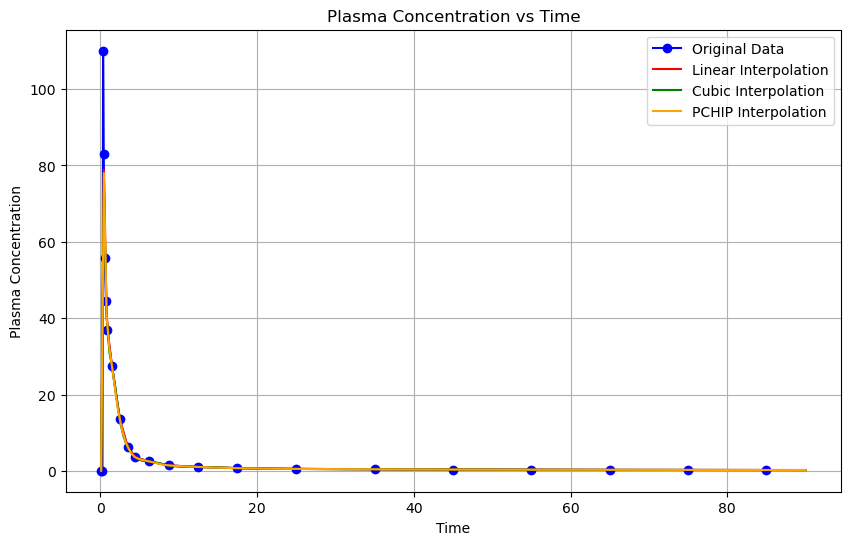

In [8]:
from data.Data_simulation import equidistant_interpolation, plot_interpolations

num_equidistant_points = 256
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['pl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['pl_list'], 
                    new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

In [9]:
# conver pchip_pl to list
pchip_pl_list = pchip_pl.tolist()

print("Plasma pchip", pchip_pl_list)
print("Plasma pchip length", len(pchip_pl_list))
# print("New time", new_rtim)

Plasma pchip [0.05901, 77.97791636147153, 40.31040430071515, 31.862336990066368, 27.060898576743114, 21.582642453065727, 16.505457173371653, 12.68174294738008, 9.677003070844767, 7.318139263725462, 5.751446037872388, 4.5506359502029845, 3.7247658398112335, 3.331238457821269, 3.070972224490761, 2.876114876343968, 2.716328211710258, 2.561274028918997, 2.3874831770078075, 2.2071413588506057, 2.0289596767518563, 1.8599978276486835, 1.7073155084782101, 1.5779724161775606, 1.4790282476838574, 1.4127258717024476, 1.3572084599887968, 1.3080910859478978, 1.2645294602635566, 1.225679293619578, 1.1906962966997674, 1.1587361801879301, 1.1289546547678713, 1.1005074311233962, 1.0725502199383097, 1.0442387318964177, 1.0154783063254227, 0.987129327069979, 0.9593124450356969, 0.9321385323150982, 0.9057184610007044, 0.8801631031850373, 0.8555833309606184, 0.8320900164199698, 0.8097940316556128, 0.7888062487600692, 0.7692375398258606, 0.7511987769455087, 0.7348008322115354, 0.720154577716462, 0.707001167

<h3> IRF <h3>

In [10]:
from data.Data_simulation import IRF

IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)

print("Parameters:", data_from_first_row['gt_parameters_list'])
print(IRF_values)

Parameters: [0.13, 0.014, 0.025, 0.05]
[0.12977305363123387, 0.129139079513796, 0.12851376012509041, 0.12789697731466368, 0.1272886145449991, 0.12668855686949754, 0.12609669091075912, 0.12551290483916094, 0.12493708835172783, 0.12436913265129092, 0.12380893042593132, 0.12325637582870413, 0.12271136445763905, 0.12217379333601448, 0.12164356089290061, 0.1211205669439681, 0.12060471267255887, 0.12009590061101538, 0.11959403462226455, 0.1190990198816532, 0.11861076285903163, 0.11812917130108157, 0.11765415421388536, 0.1171856218457334, 0.11672348567016579, 0.11626765836924603, 0.11581805381706277, 0.11537458706345659, 0.11493717431796949, 0.1145057329340129, 0.11408018139325236, 0.11366043929020474, 0.11324642731704647, 0.1128380672486285, 0.11243528192769638, 0.11203799525031154, 0.11164613215147219, 0.11125961859092998, 0.11087838153920071, 0.11050234896376578, 0.11013144981546194, 0.10976561401505719, 0.10940477244000955, 0.1090488569114068, 0.10869780018108455, 0.1083515359189199, 0.10

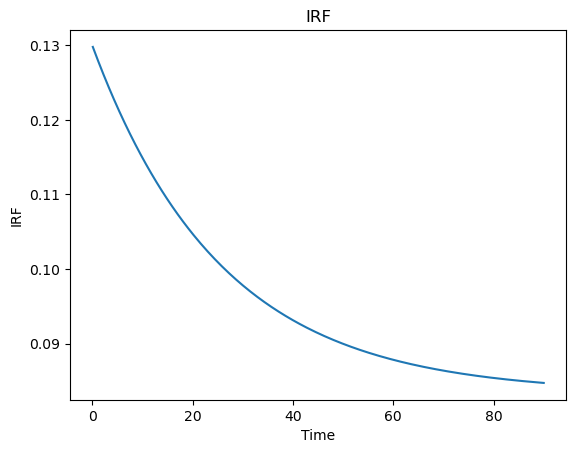

In [11]:
plt.plot(new_rtim, IRF_values)
plt.xlabel('Time')
plt.ylabel('IRF')
plt.title('IRF')
plt.show()

In [12]:
print(data_from_first_row['gt_parameters_list'])

k1 = data_from_first_row['gt_parameters_list'][0]
k2 = data_from_first_row['gt_parameters_list'][1]
k3 = data_from_first_row['gt_parameters_list'][2]
k4 = 0
print((k2 + k3 + k4))
alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha1)
alpha1 /= 2

print(alpha1)

alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha2)
alpha2 /= 2
print(alpha2)

print(np.exp(alpha1*0.1))

print(len(IRF_values))

[0.13, 0.014, 0.025, 0.05]
0.039
0.0
0.0
0.078
0.039
1.0
256


In [13]:
def IRF(gt_parameters_list, equidistant_rtim):
    """
    Calculates the impulse response function (IRF) for the given ground truth parameters and equidistant timepoints.

    Parameters:
    gt_parameters_list (list): List of ground truth parameters.
    equidistant_rtim (list): Equidistant timepoints.

    Returns:
    list: The IRF values.
    """
    # Extract ground truth parameters
    k1 = gt_parameters_list[0]
    k2 = gt_parameters_list[1]
    k3 = gt_parameters_list[2]
    k4 = 0 # For the current data, k4 is always 0

    # Calculate alphas:
    alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha1 /= 2

    alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha2 /= 2

    # Calculate IRF
    IRF = []
    for t in equidistant_rtim:
        value = ( (k3 + k4 - alpha1) * np.exp(-alpha1 * t) + (alpha2 - k3 - k4) * np.exp(-alpha2 * t) ) / (alpha2 - alpha1)
        value *= k1
        IRF.append(value)
    
    return IRF

<h2> C Tissue <h2>

In [14]:
def c_tissue(IRF_values, pchip_pl):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add required dimensions for conv1d
    IRF_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # Perform the convolution using PyTorch's conv1d function
    # The groups argument ensures that each input channel is convolved with its own filter (IRF_tensor)
    result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)

    # Normalize the IRF tensor
    normalized_result_tensor = result_tensor * (90/len(IRF_values)) # Multiply by dt

    # Remove the extra dimensions and convert the tensor back to a list
    simulated_tac_values = normalized_result_tensor.squeeze().tolist()

    return simulated_tac_values

In [ ]:
# Normalization methods:

# normalize the IRF tensor
#IRF_tensor = IRF_tensor / torch.norm(IRF_tensor)

# Normalize the convolution result
#num_points = len(IRF_values) 
#normalized_result_tensor = result_tensor / np.sqrt(num_points)

In [16]:
def c_tissue3(IRF_values, pchip_pl):
    # Convert lists to PyTorch tensors
    irf_tensor = torch.tensor(IRF_values).float().view(1, 1, -1)
    pchip_tensor = torch.tensor(pchip_pl).float().view(1, 1, -1)

    # Check if the IRF tensor length is odd, if not, append a zero
    if irf_tensor.shape[-1] % 2 == 0:
        # Append a zero to make the length odd
        irf_tensor = F.pad(irf_tensor, (0, 1))
    
    # Perform the convolution
    result_tensor = F.conv1d(pchip_tensor, irf_tensor, padding='same')

    # Convert the result back to a list
    simulated_tac_values = result_tensor.squeeze().tolist()

    return simulated_tac_values

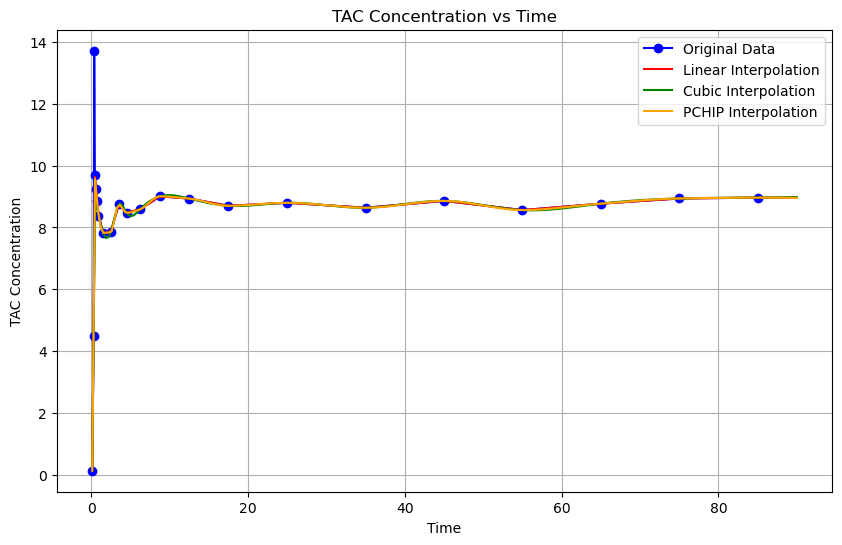

In [17]:
# Get the interpolated tac values
new_rtim, linear_tac, cubic_tac, pchip_tac = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['tac_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['tac_list'], 
                    new_rtim, linear_tac, cubic_tac, pchip_tac, 'TAC')

/var/folders/zv/0t7_y4d14yg29z856cdmpbvc0000gn/T/ipykernel_1947/4216439475.py:18: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1009.)
  result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)


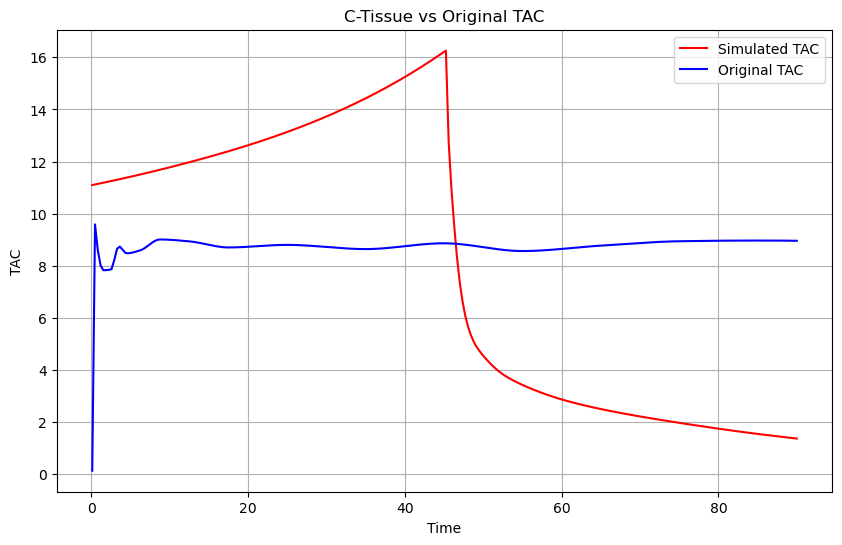

In [18]:
simulated_c_tissue_values = c_tissue(IRF_values, pchip_pl)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

<h3> Numpy <h3>

In [19]:
def c_tissue4(IRF_values, pchip_pl):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """

    # Normalize IRF values
    IRF_values = IRF_values / np.linalg.norm(IRF_values)

    # Compute the convolution of the two lists
    simulated_c_tissue_values = np.convolve(IRF_values, pchip_pl, mode='same')

    return simulated_c_tissue_values.tolist()

In [20]:
simulated_c_tissue_values = c_tissue4(IRF_values, pchip_pl)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))


pl_chip: 256
IRF: 256
[21.256101761190102, 21.251636504912753, 21.24738894864843, 21.243361941767137, 21.239557849977885, 21.235978557517054, 21.23262546930693, 21.229499513084818, 21.226601141502954, 21.22393033419992, 21.221486599843637, 21.219268978146555, 21.217276041853314, 21.215505898701213, 21.21395619335403, 21.212624109309335, 21.21150637077981, 21.21059924454888, 21.20989854180106, 21.20939961992719, 21.20909738430516, 21.208986290056266, 21.209060343777583, 21.209313105250693, 21.20973768912711, 21.210326766590654, 21.211072566997185, 21.2119668794919, 21.21300105460457, 21.21416556274694, 21.21544414051861, 21.216819429693317, 21.218275432880887, 21.219797505941617, 21.221372350504154, 21.22298800658548, 21.224633845311736, 21.226300561738306, 21.22798016776805, 21.229665985166054, 21.23135263866991, 21.233036049193903, 21.23471342712607, 21.236383265716732, 21.238045334557263, 21.239700673147908, 21.241351584553424, 21.243001629145283, 21.244655618429366, 21.2463196089578

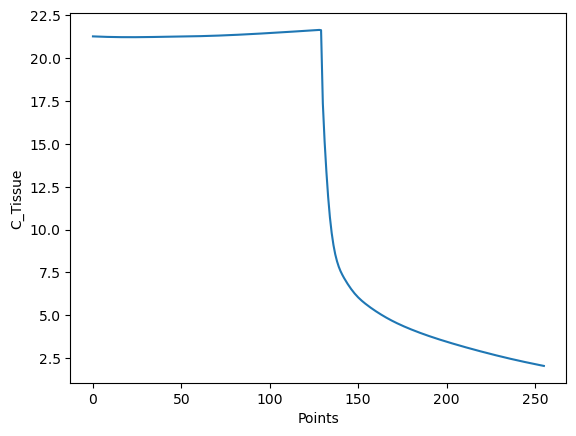

In [21]:
# Plot c_tissue4 values

plt.plot(simulated_c_tissue_values)
plt.xlabel('Points')
plt.ylabel('C_Tissue')
plt.show()

<h3> Scipy <h3>

In [30]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')[:num_points]

    # Normalize the convolution result
    normalized_result_tensor = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_result_tensor


In [31]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

#print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 256
IRF: 256
256


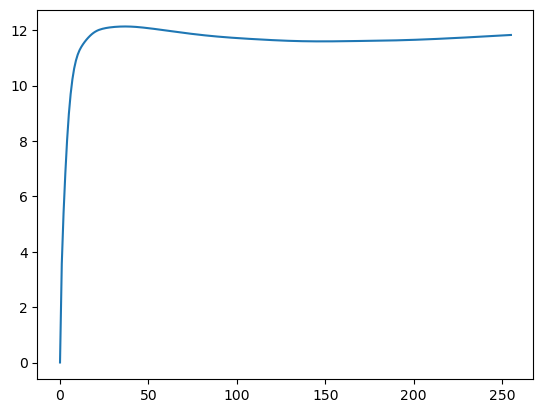

In [32]:
plt.plot(simulated_c_tissue_values)
plt.show()

<h2>Simulated TAC <h2>

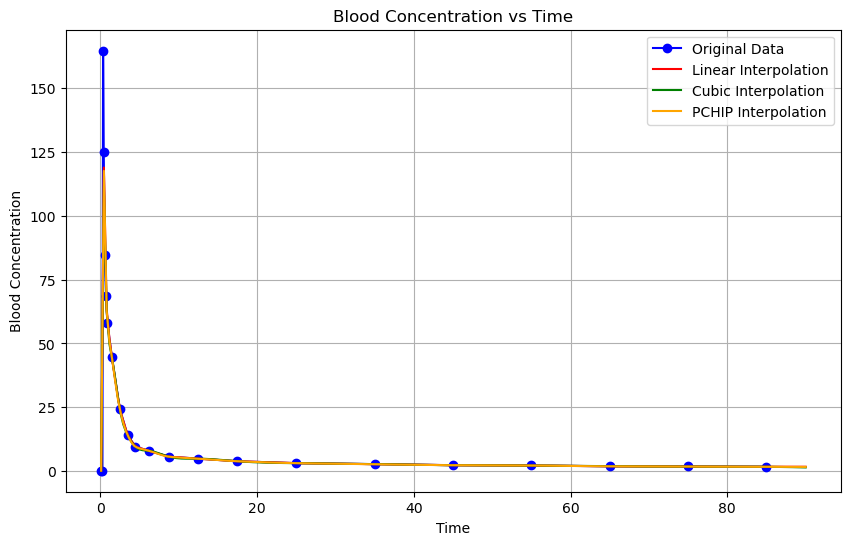

In [33]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [34]:
print("Blood values:", len(pchip_bl))
print("C_tissue", len(simulated_c_tissue_values))
print("vb:", data_from_first_row['gt_parameters_list'][3])

Blood values: 256
C_tissue 256
vb: 0.05


In [35]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values
    

Simulated TAC: [0.006932585288004349, 9.272833967541189, 8.262440322126665, 9.023528601770513, 9.81632860022008, 10.322827650826472, 10.63505143306021, 10.869008042498683, 11.031929373653146, 11.135061486881588, 11.217315802962279, 11.26916674425785, 11.314062374081729, 11.378703506147986, 11.443519226489506, 11.505096121337628, 11.561969349481135, 11.611347817311543, 11.650018833898526, 11.678828842074308, 11.699207904508786, 11.712770236587438, 11.721434372630961, 11.72742170058354, 11.733255016704883, 11.740872507906147, 11.747797284748298, 11.753691782635167, 11.758669103326428, 11.762804406208701, 11.766135104668951, 11.768661059787174, 11.770344771384819, 11.771111566465127, 11.770849785080967, 11.769410963665281, 11.766787089812702, 11.763181624592063, 11.758653729210033, 11.75326533670019, 11.747083050129358, 11.740178121076807, 11.732626428407176, 11.724508457333235, 11.715909278764425, 11.706918528937374, 11.69763038932443, 11.688143566816532, 11.67856127417657, 11.6689912107

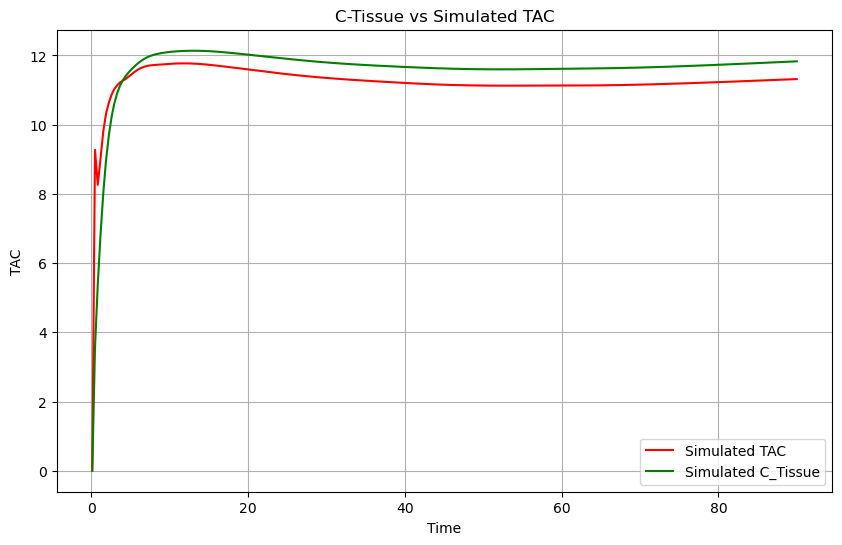

In [36]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)
print("Simulated TAC:", simulated_tac_values)
print("CTissue:" , simulated_c_tissue_values)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()

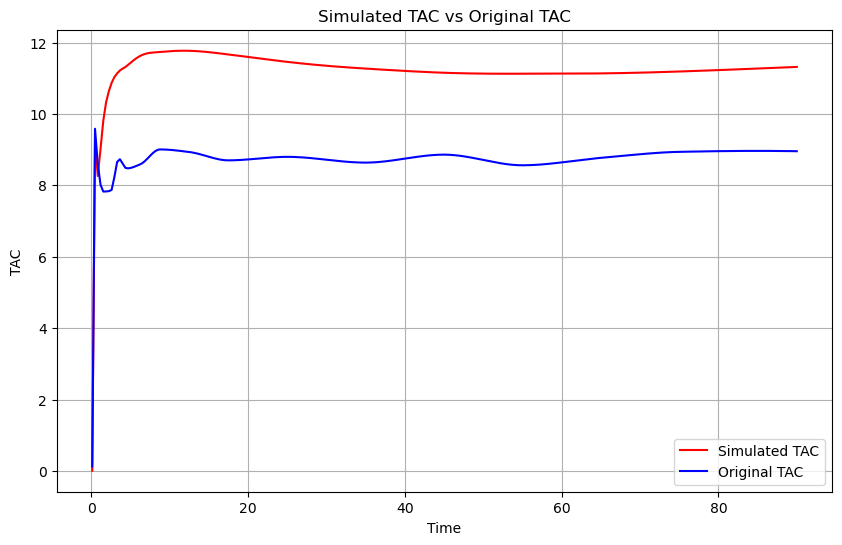

In [37]:

# Plot the simulated TAC values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Simulated TAC vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()